# Import

In [1]:
from gurobipy import*
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.lines as mlines
import osmnx as ox
import networkx as nx
import numpy as np
import csv
import random
import matplotlib.lines as lines
import matplotlib.text as mtext
import matplotlib.transforms as mtransforms
from math import radians, sin, cos, acos
%matplotlib inline
ox.config(log_console=True, use_cache=True)
ox.__version__

ModuleNotFoundError: No module named 'geopandas'

In [3]:
import sys
'geopandas' in sys.modules

True

# Sets & Parameters

In [4]:
x = {} #variable
w = {} # w(ijk)=1 if goes (i,j) to (j,k) 
a = {} #penalty parameter for unfavorable arc
c = {} #cost on arc(i,j)
r = {} # r(i,j,k) = 1 if (i,j) -> (j,k) turns left
b = 5 # turn left penalty
A = set() #Arc set
N = set() #Node set
label = 70 
Ad = {(453417606, 1720141763), (1720141774, 1720141775),(1727367840, 1727367831),(4776702416, 4776702415),(453417647, 453417644)}
#Ad = must visit arc's set
o = 0 #dummy source
d = 10 #dummy sink
s = 4382162395 #starting point

# Step1: Generate real network

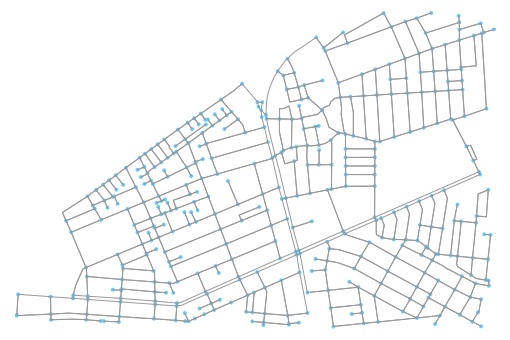

In [5]:
left_corner = [23.015023, 120.176074] ## 輸入左上
right_corner = [23.00431, 120.1931] ## 輸入右下

# create network from that bounding box
G1 = ox.graph_from_bbox(left_corner[0], right_corner[0], right_corner[1], left_corner[1], network_type='drive_service', simplify=True)
G1 = ox.project_graph(G1)
fig, ax = ox.plot_graph(G1)

# Step2: Find node

find node id: 5850815416
find node id2: 1708051040


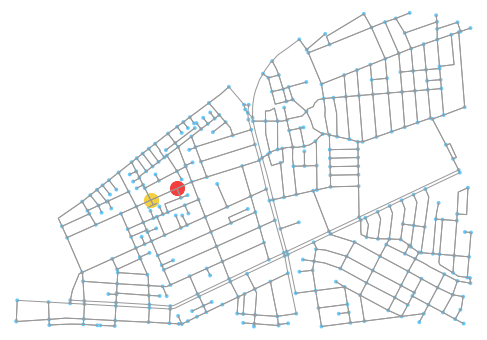

In [9]:
find_node = [23.00513, 120.18004] ## 輸入要找的座標
find_node2 = [23.00861, 120.18125]

#node_id =  ox.get_nearest_node(G1, find_node)
node_id =  5850815416
node_id2 = ox.get_nearest_node(G1, find_node2)

print("find node id: %d" % node_id)
print("find node id2: %d" % node_id2)

G1 = ox.graph_from_bbox(left_corner[0], right_corner[0], right_corner[1], left_corner[1], network_type='drive_service', simplify=True)
fig, ax = ox.plot_graph(G1, show=False,close=False)
#fig, ax = ox.plot_graph(G1, annotate=True,node_size=50,fig_height=30,fig_width=30)

ax.scatter(G1.node[node_id]['x'], G1.node[node_id]['y'], s=200, c='#f43f3f', marker='o')#r1
ax.scatter(G1.node[node_id2]['x'], G1.node[node_id2]['y'], s=200, c='#F4D03F', marker='o')#y2
plt.show()

# Others 

In [7]:
# create arc, node
# c[i,j] here is 'length' of the arc need to transfer to time
for (i,j) in G.edges(
    A.add((i,j))
    c[i,j] = G.get_edge_data(i,j)[0]['length']
    if G.get_edge_data(i,j)[0]['oneway'] == "False":
        A.add((j,i))
        c[j,i] = c[i,j]
    N.add(i)
    N.add(j)
N.add(o)
N.add(d)
A.add((s,d))
A.add((d,d))
A.add((o,s))
# set unfavorable arc,  1 is default
for (i,j) in A:
    a[i,j] = 1
# link from dummy source and to dummy sink cost 0
c[o,s] = 0
c[s,d] = 0
c[d,d] = 0
# set turn left parameter, now I use 0.5 to represent U turn
for (i,j) in A:
    for k in N:
        if (j,k) in A:
            r[i,j,k] = 0
            if(i==k):
                r[i,j,k] = 0.5

SyntaxError: invalid syntax (<ipython-input-7-debb307161e6>, line 5)

# Model

In [175]:
model = Model("post_route")
for (i,j) in A:
    for l in range(label):
        x[i,j,l] = model.addVar(vtype = "B",name="x(%s,%s,%s)"%(i,j,l))
        for k in N:
            if(j,k) in A:
                w[i,j,k,l] = model.addVar(vtype = "B",name="w(%s,%s,%s,%s)"%(i,j,k,l))
model.update()
# flow balance
for j in N:
    for l in range(label-1):
        model.addConstr(quicksum(x[i,j,l]for i in N if (i,j)in A) == quicksum(x[j,i,l+1]for i in N if (j,i)in A),name = "flow(%s,%s)"%(j,l))
# must go arcs
for (i,j) in Ad:
    model.addConstr(quicksum(x[i,j,l]for l in range(label))>=1)
# dummy sink
    model.addConstr(quicksum(x[s,d,l]for l in range(label))==1,name="dummy_sink")
# dummy source
for (i,j) in A:
    if (i,j) !=(o,s):
        model.addConstr(x[i,j,0]==0)
# label
for l in range(label):
    model.addConstr(quicksum(x[i,j,l]for (i,j)in A)==1)
# turn left
for (i,j) in A:
    for k in N:
        if(j,k) in A:
            for l in range(label-1):
                model.addConstr(x[i,j,l]+x[j,k,l+1]<=w[i,j,k,l]+1)
model.setObjective(quicksum(a[i,j]*c[i,j]*x[i,j,l]for (i,j,l)in x)+b*quicksum(r[i,j,k]*w[i,j,k,l]for(i,j,k,l)in w),GRB.MINIMIZE)
model.optimize()
model.write("test.lp")

Optimize a model with 149657 rows, 178990 columns and 531350 nonzeros
Variable types: 0 continuous, 178990 integer (178990 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 5e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 107369 rows and 115218 columns
Presolve time: 3.48s
Presolved: 42288 rows, 63772 columns, 194639 nonzeros
Variable types: 0 continuous, 63772 integer (63772 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   16347    1.3595804e+03   3.280649e-01   1.632799e+09      5s
   20394    8.0155992e+04   0.000000e+00   9.983426e+05      6s
   56159    1.9371125e+03   0.000000e+00   0.000000e+00      8s
   56159    1.9371125e+03   0.000000e+00   0.000000e+00      8s
Concurrent spin time: 0.47s

Solved with primal simplex

Root relaxation: objective 1.937112e+

# Result

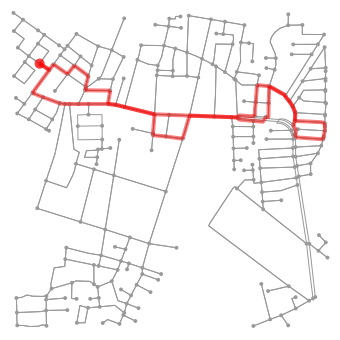

(<Figure size 469.91x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a311b7f60>)

In [176]:
# draw result
route = []
for l in range(label):
    for (i,j) in A:
        if x[i,j,l].X>0 and i!=10 and j!=10:
            route.append(j)
ox.plot.plot_graph_route(G,route)

# Compute IIS

In [166]:
model.computeIIS()
for c in model.getConstrs():
    if c.IISconstr:
        print(c.ConstrName)

# Trace (x,y) coordinate of a node

In [177]:
G.node[1727367831]

{'y': 23.0140238, 'x': 120.2132138, 'osmid': 1727367831}